# Predicting Kills and Headshots for CS

**Goal**: Predict the kills and headshots for a player's next game using historical HLTV data.

## Definitions

- **Rating**: A metric calculated by comparing a player's average stats:
  - Kills per round
  - Survived rounds per round
  - Number of rounds with multiple kills
  
- **KAST**: The percentage of rounds where a player contributes in one or more of the following ways:
  - Killing an enemy
  - Assisting a teammate
  - Surviving a round
  - Getting revenge on an enemy (trading for a teammate's death)

- **K-D Diff**: The difference between kills and deaths (Kills - Deaths).

- **ADR**: The average damage per round, measuring the damage output of a player.

- **FK Diff**: The difference in first kills (positive or negative) a player contributes, often reflecting early-round aggression.


In [1]:
import os, sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings, joblib

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

warnings.filterwarnings("ignore")

In [2]:
project_root = os.path.abspath(os.path.join("..", "scraper"))
sys.path.insert(0, project_root)
from utils import *

## Import Data

In [3]:
# Connect to the AWS database
connection, cursor = database_connection_and_cursor("CSGO")
cursor.execute(
    """SELECT * FROM hltv_stats"""
)
cs_data = cursor.fetchall()

In [4]:
cols = [
    'ID', 'Event', 'Date', 'Map', 'Map Number', 'Team', 'Name',
    'Kills', 'Headshots', 'Assists', 'Deaths', 'Kast', 'K-D Diff',
    'ADR', 'FK Diff', 'Rating', 'Team Score', 'Opponent Score',
    'Teammate 1', 'Teammate 2', 'Teammate 3', 'Teammate 4', 'Opponent 1',
    'Opponent 2', 'Opponent 3', 'Opponent 4', 'Opponent 5', 'Teammate 5',
    'Opponent 6', 'Opponent 7', 'Teammate 6'
]
cs_data = pd.DataFrame(cs_data, columns=cols)

In [5]:
# Convert object statistic columns to float values
cs_data["Kast"] = cs_data["Kast"].astype("float")
cs_data["ADR"] = cs_data["ADR"].astype("float")
cs_data["Rating"] = cs_data["Rating"].astype("float")

In [6]:
# Unique teams and players
team_df = cs_data[["Date", "Name", "Team"]].drop_duplicates()
team_df.reset_index(drop=True, inplace=True)
team_df.head()

,Date,Name,Team
0,2020-01-02 10:00:00,raalz,Ambush
1,2020-01-02 10:00:00,BERRY,Ambush
2,2020-01-02 10:00:00,EMENK,Rocketlauncher$
3,2020-01-02 10:00:00,sausol,Rocketlauncher$
4,2020-01-02 10:00:00,DeathZz,Rocketlauncher$


In [7]:
# Concat the data
cs_data = \
cs_data.merge(
    right=team_df.add_prefix("Opponent "),
    left_on=["Date", "Opponent 1"],
    right_on=["Opponent Date", "Opponent Name"],
    how="left",
).drop(columns=["Opponent Date", "Opponent Name"])

# Opponents
opponents = cs_data.pop("Opponent Team")

# Append back to the dataframe
cs_data.insert(5, "Opponent Team", opponents)

cs_data.head()

,ID,Event,Date,Map,Map Number,Opponent Team,Team,Name,Kills,Headshots,...,Teammate 4,Opponent 1,Opponent 2,Opponent 3,Opponent 4,Opponent 5,Teammate 5,Opponent 6,Opponent 7,Teammate 6
0,0,GG.BET Winter Cup,2020-01-02 10:00:00,Dust2,3,Rocketlauncher$,Ambush,raalz,17,10,...,BERRY,SOKER,shhhack,sausol,EMENK,DeathZz,,,,
1,1,GG.BET Winter Cup,2020-01-02 10:00:00,Dust2,3,Rocketlauncher$,Ambush,BERRY,15,7,...,raalz,SOKER,shhhack,sausol,EMENK,DeathZz,,,,
2,2,GG.BET Winter Cup,2020-01-02 10:00:00,Overpass,1,Ambush,Rocketlauncher$,EMENK,25,5,...,SOKER,raalz,smF,ckay,BERRY,doktizh,,,,
3,3,GG.BET Winter Cup,2020-01-02 10:00:00,Overpass,1,Ambush,Rocketlauncher$,sausol,21,14,...,SOKER,raalz,smF,ckay,BERRY,doktizh,,,,
4,4,GG.BET Winter Cup,2020-01-02 10:00:00,Overpass,1,Ambush,Rocketlauncher$,DeathZz,20,13,...,SOKER,raalz,smF,ckay,BERRY,doktizh,,,,


In [8]:
# Info on the dataframe
cs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471036 entries, 0 to 471035
Data columns (total 32 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   ID              471036 non-null  int64         
 1   Event           471036 non-null  object        
 2   Date            471036 non-null  datetime64[ns]
 3   Map             471036 non-null  object        
 4   Map Number      471036 non-null  object        
 5   Opponent Team   471036 non-null  object        
 6   Team            471036 non-null  object        
 7   Name            471036 non-null  object        
 8   Kills           471036 non-null  int64         
 9   Headshots       471036 non-null  int64         
 10  Assists         471036 non-null  int64         
 11  Deaths          471036 non-null  int64         
 12  Kast            471036 non-null  float64       
 13  K-D Diff        471036 non-null  int64         
 14  ADR             471036 non-null  flo

In [9]:
len(cs_data["Name"].unique())

6099

In [10]:
# Number of unique players
print(f"There's {len(cs_data['Name'].unique())} unique players")

There's 6099 unique players


In [11]:
# Number of unique teams
print(f"There's {len(cs_data['Team'].unique())} unique teams")

There's 1929 unique teams


In [12]:
# Number of games played by a gamer
cs_data["Name"].value_counts()

Name
Lucky          1510
MiGHTYMAX       881
Surreal         876
aVN             872
iDISBALANCE     856
               ... 
Archie            1
ChiNny            1
ComPlex           1
Strauchanie       1
risen             1
Name: count, Length: 6099, dtype: int64

In [13]:
# Maps played
cs_data["Map"].value_counts()

Map
Mirage       75849
Inferno      72226
Nuke         66782
Ancient      61533
Anubis       48415
Vertigo      47132
Overpass     45668
Dust2        34160
Train        18670
Best of 3      521
Cache           30
All             20
Best of 2       20
Tuscan          10
Name: count, dtype: int64

## Exploratory Data Analaysis

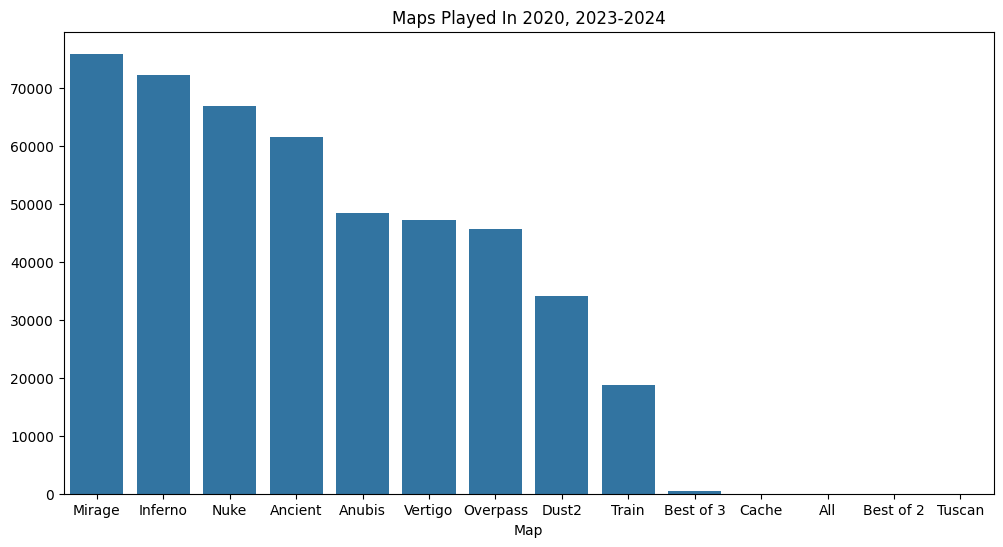

In [14]:
# Visual of the data
plt.figure(figsize=(12, 6))
sns.barplot(x=cs_data["Map"].value_counts().keys(), y=cs_data["Map"].value_counts().values)
plt.title("Maps Played In 2020, 2023-2024")
plt.show()

In [15]:
# Store the stats only as a dataframe
cs_stats = cs_data.iloc[:, :].query("(Map!='Best of 3') and (Map!='Best of 2') and (Map!= 'All')").reset_index(drop=True)
cs_stats.shape

(470475, 32)

In [16]:
# Map values after querying
cs_stats["Map"].value_counts()

Map
Mirage      75849
Inferno     72226
Nuke        66782
Ancient     61533
Anubis      48415
Vertigo     47132
Overpass    45668
Dust2       34160
Train       18670
Cache          30
Tuscan         10
Name: count, dtype: int64

In [17]:
# Drop the missing values
cs_stats = cs_stats.dropna(axis=1).reset_index(drop=True)

In [18]:
# Missing values
cs_stats.isna().sum()

ID                0
Event             0
Date              0
Map               0
Map Number        0
Opponent Team     0
Team              0
Name              0
Kills             0
Headshots         0
Assists           0
Deaths            0
Kast              0
K-D Diff          0
ADR               0
FK Diff           0
Rating            0
Team Score        0
Opponent Score    0
Teammate 1        0
Teammate 2        0
Teammate 3        0
Teammate 4        0
Opponent 1        0
Opponent 2        0
Opponent 3        0
Opponent 4        0
Opponent 5        0
dtype: int64

In [19]:
# Describe the data
cs_stats.drop(["ID", "Date"], axis=1).describe().round(3)

,Kills,Headshots,Assists,Deaths,Kast,K-D Diff,ADR,FK Diff,Rating,Team Score,Opponent Score
count,470475.000,470475.000,470475.000,470475.000,470475.000,470475.000,470475.000,470475.000,470475.000,470475.000,470475.000
mean,16.355,7.902,4.693,16.447,70.455,-0.092,73.344,-0.004,1.060,12.257,12.258
std,6.157,3.832,2.643,4.814,11.769,6.528,18.591,2.338,0.328,4.358,4.358
min,0.000,0.000,0.000,0.000,7.100,-29.000,0.000,-14.000,0.040,0.000,0.000
25%,12.000,5.000,3.000,13.000,63.200,-5.000,60.600,-2.000,0.840,9.000,9.000
50%,16.000,7.000,4.000,16.000,70.800,0.000,72.400,0.000,1.040,13.000,13.000
75%,20.000,10.000,6.000,19.000,78.600,4.000,84.900,1.000,1.260,16.000,16.000
max,71.000,38.000,28.000,62.000,100.000,40.000,193.500,13.000,3.190,40.000,40.000


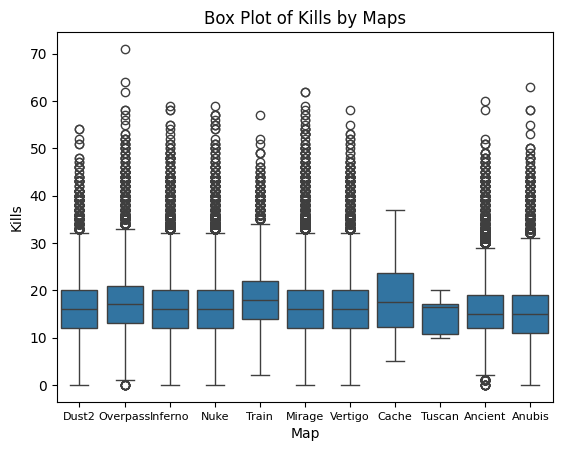

In [20]:
# Distribution of kills by maps
sns.boxplot(data=cs_stats, x="Map", y="Kills")
plt.title("Box Plot of Kills by Maps")
plt.xticks(fontsize=8)
plt.show()

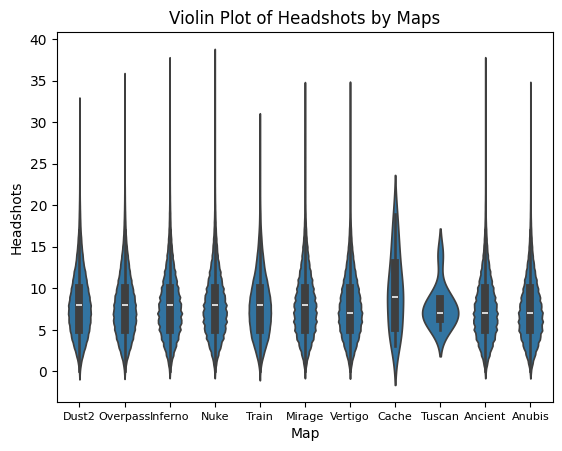

In [21]:
# Distribution of headshots by maps
sns.violinplot(data=cs_stats, x="Map", y="Headshots")
plt.title("Violin Plot of Headshots by Maps")
plt.xticks(fontsize=8)
plt.show()

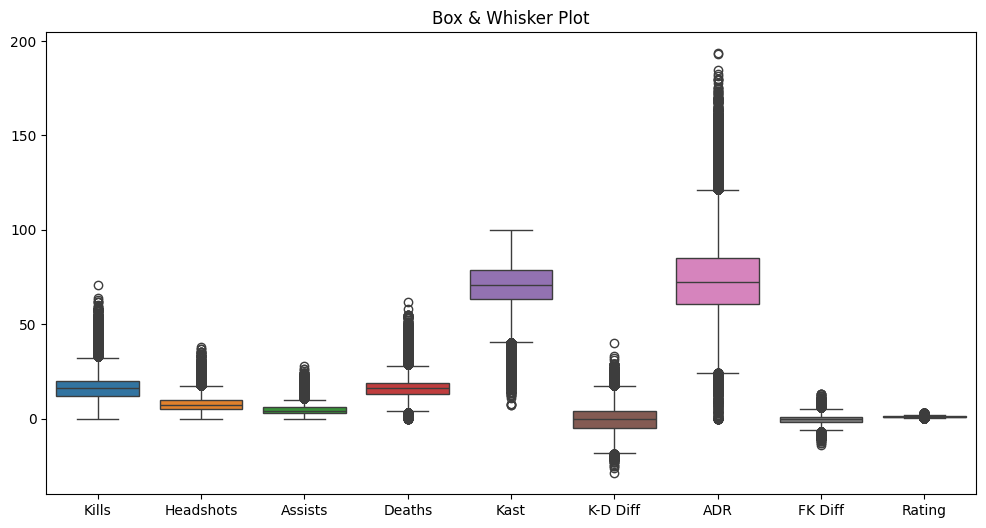

In [22]:
# Box & Whisker Plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=cs_stats.drop(columns=["ID", "Team Score", "Opponent Score"]))
plt.title("Box & Whisker Plot")
plt.show()

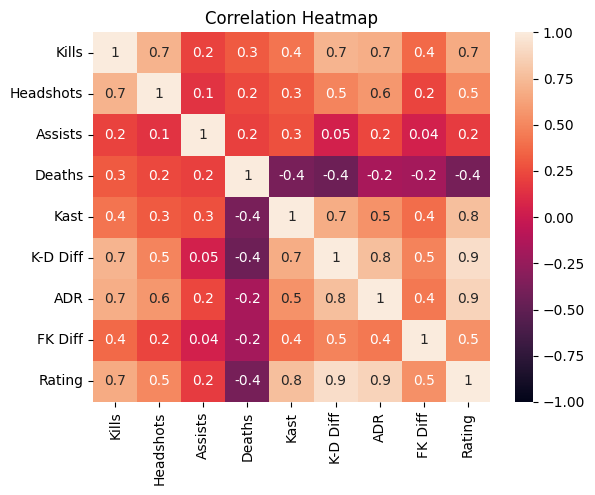

In [23]:
# Correlation matrix
corr_matrix = cs_stats.drop(columns=["ID", "Team Score", "Opponent Score"]).corr(numeric_only=True)

# Plot Heatmap
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, fmt=".1g")
plt.title("Correlation Heatmap")
plt.show()

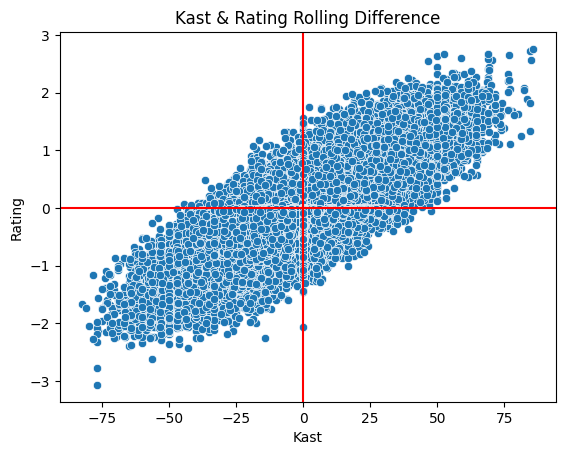

In [24]:
# Plot the relationship between Kast and Rating
sns.scatterplot(data=cs_data[["Kast", "Rating"]].diff(), x="Kast", y="Rating")
plt.axhline(0, c="r")
plt.axvline(0, c="r")
plt.title("Kast & Rating Rolling Difference")
plt.show()

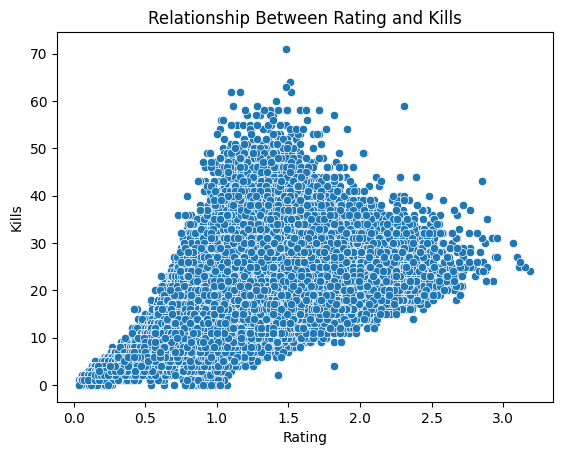

In [25]:
sns.scatterplot(data=cs_data, x="Rating", y="Kills")
plt.title("Relationship Between Rating and Kills")
plt.show()

## Data Preprocessing

- Combine Map Statistics
    - **Map 1**
    - **Map 2**
    - **Map 3**
    - **Map 1-2**
    - **Map 1-3**

- Drop Columns
    - **ID**
    - **K-D Diff**
    - **FK Diff**
    - **Team & Opponent Score**
    - **Date**
    - **Event**

- Encode
    - **Date**
    - **Group Players**
    - **Group Teams**

In [26]:
# Drop the columns
cs_stats_f = cs_stats.drop(columns=["ID", "K-D Diff", "FK Diff", "Team Score", "Opponent Score"])

# Filter the dataset to only MAPS 1, 2, and 3
cs_stats_f = cs_stats_f.groupby(by=["Event", "Date", "Team", "Opponent Team"]).filter(lambda group: set(group["Map Number"]).issubset({"1", "2", "3"}))
cs_stats_f.reset_index(drop=True, inplace=True)
cs_stats_f.shape

(411354, 23)

In [27]:
def total_maps_statistics(df: pd.DataFrame, three_maps: bool=False) -> pd.DataFrame:
    """
    Totals up the statistics on the dataframe and returns a new dataframe

    Params:
        df (pd.DataFrame): The dataframe
        three_maps (bool): If it is three maps

    Returns:
        df (pd.DataFrame): New dataframe
    """
    df = df.copy()
    # Total up the numbers
    stat_columns = ["Kills", "Headshots", "Assists", "Deaths", "Kast", "ADR", "Rating"]
    # If statistics of three maps should be sum
    if three_maps:
        for stat_column in stat_columns:
            idx = cs_stats_f.columns.get_indexer([stat_column])[0]
            if stat_column in ["Kast", "ADR", "Rating"]:
                df.insert(loc=idx, column=stat_column, value=(df[f"{stat_column} Map 1"] + df[f"{stat_column} Map 2"] + df[f"{stat_column} Map 3"])/3)
            else:
                df.insert(loc=idx, column=stat_column, value=df[f"{stat_column} Map 1"] + df[f"{stat_column} Map 2"] + df[f"{stat_column} Map 3"])
        drop_cols = [f"{stat_column} Map 1" for stat_column in stat_columns] + [f"{stat_column} Map 2" for stat_column in stat_columns] + [f"{stat_column} Map 3" for stat_column in stat_columns]
        df.drop(columns=drop_cols, inplace=True)
        df["Map Number"] = "MAPS 1-3"
        return df
    # Only two maps
    else:
        for stat_column in stat_columns:
            idx = cs_stats_f.columns.get_indexer([stat_column])[0]
            if stat_column in ["Kast", "ADR", "Rating"]:
                df.insert(loc=idx, column=stat_column, value=(df[f"{stat_column} Map 1"] + df[f"{stat_column} Map 2"])/2)
            else:
                df.insert(loc=idx, column=stat_column, value=df[f"{stat_column} Map 1"] + df[f"{stat_column} Map 2"])
        drop_cols = [f"{stat_column} Map 1" for stat_column in stat_columns] + [f"{stat_column} Map 2" for stat_column in stat_columns]
        df.drop(columns=drop_cols, inplace=True)
        df["Map Number"] = "MAPS 1-2"
        return df

In [28]:
# Seperate the Maps to make it easier merge
map_1 = cs_stats_f[cs_stats_f["Map Number"] == "1"]
map_2 = cs_stats_f[cs_stats_f["Map Number"] == "2"]
map_3 = cs_stats_f[cs_stats_f["Map Number"] == "3"]

# Merge the dataframes to calculate for Maps 1-2
map_1_and_2 = pd.merge(
    left=map_1,
    right=map_2[
        ["Event", "Date", "Name", "Team", "Opponent Team", "Kills", "Headshots", "Assists", "Deaths", "Kast", "ADR", "Rating"]
        ],
    suffixes = (" Map 1", " Map 2"),
    on=["Event", "Date", "Name", "Team", "Opponent Team"],
)

# Merge the dataframe to calculate for Maps 1-3
map_1_and_2_and_3 = map_1_and_2.merge(
    right=map_3[
        ["Event", "Date", "Name", "Team", "Opponent Team", "Kills", "Headshots", "Assists", "Deaths", "Kast", "ADR", "Rating"]
    ],
    on=["Event", "Date", "Name", "Team", "Opponent Team"],
).rename(columns={
    "Kills": "Kills Map 3",
    "Headshots": "Headshots Map 3",
    "Assists": "Assists Map 3",
    "Deaths": "Deaths Map 3",
    "Kast": "Kast Map 3",
    "ADR": "ADR Map 3",
    "Rating": "Rating Map 3"
    })

# Apply the function
map_1_and_2 = total_maps_statistics(df=map_1_and_2)
map_1_and_2_and_3 = total_maps_statistics(df=map_1_and_2_and_3, three_maps=True)

In [29]:
# Change the Map Number column
map_1["Map Number"] = "MAPS 1"
map_3["Map Number"] = "MAPS 3"

In [30]:
# Exclude Map 2
cs_maps_and_stats = pd.concat(
    [
        map_1,
        map_3,
        map_1_and_2,
        map_1_and_2_and_3
    ],
    ignore_index=True
)

In [31]:
# Drop columns that won't be needed for the ML model
ml_model = cs_maps_and_stats.copy()
ml_model.drop(columns=["Event", "Date", "Map"], inplace=True)

# Filter to players that played at least 10 matches on a map with a team
ml_model = ml_model.groupby(["Name", "Team", "Map Number"]).filter(lambda group: len(group)>=10)
ml_model.reset_index(drop=True, inplace=True)
ml_model.shape

(390613, 20)

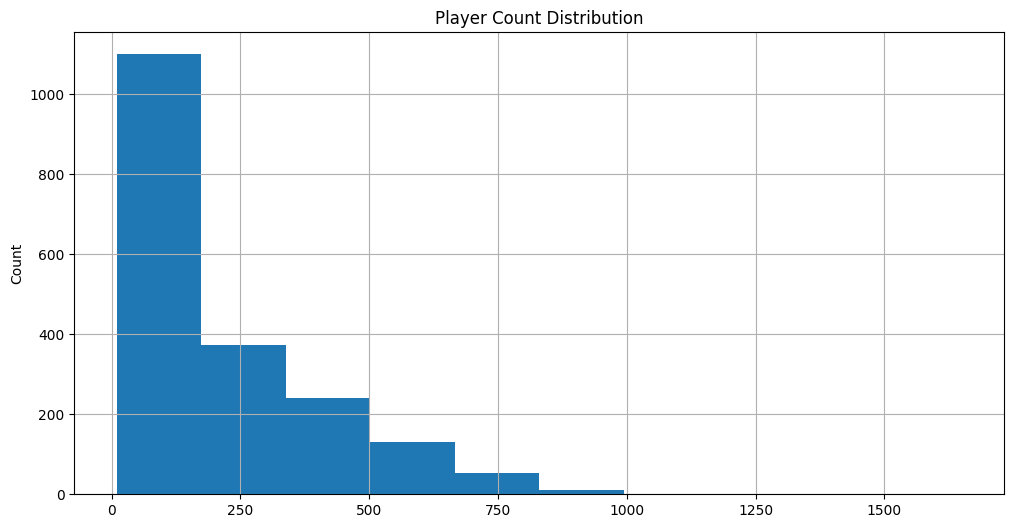

In [32]:
ml_model["Name"].value_counts().hist(figsize=(12, 6))
plt.title("Player Count Distribution")
plt.ylabel("Count")
plt.show()

In [33]:
# Class proportions
ml_model["Map Number"].value_counts()/sum(ml_model["Map Number"].value_counts())

Map Number
MAPS 1      0.366718
MAPS 1-2    0.366334
MAPS 3      0.133608
MAPS 1-3    0.133339
Name: count, dtype: float64

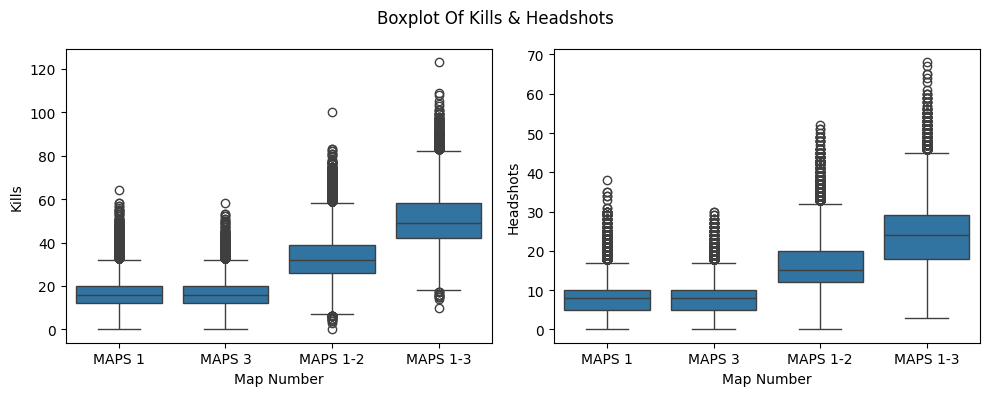

In [34]:
# The distribution of kills and headshots by MAPS
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sns.boxplot(data=ml_model, x="Map Number", y="Kills", ax=ax[0])
sns.boxplot(data=ml_model, x="Map Number", y="Headshots", ax=ax[1])
fig.suptitle("Boxplot Of Kills & Headshots")
fig.tight_layout()
plt.show()

In [35]:
# There is a large standard deviation
ml_model.describe()

,Kills,Headshots,Assists,Deaths,Kast,ADR,Rating
count,390613.000000,390613.000000,390613.000000,390613.000000,390613.000000,390613.000000,390613.000000
mean,26.990907,13.050467,7.753900,26.791999,70.922432,73.584572,1.069904
std,14.400624,7.826050,4.845279,13.483049,9.964619,16.049705,0.280586
min,0.000000,0.000000,0.000000,0.000000,7.100000,0.000000,0.040000
25%,16.000000,7.000000,4.000000,16.000000,65.000000,62.950000,0.886667
50%,24.000000,11.000000,7.000000,23.000000,71.400000,72.900000,1.055000
75%,36.000000,17.000000,11.000000,36.000000,77.350000,83.300000,1.235000
max,123.000000,68.000000,43.000000,96.000000,100.000000,193.100000,3.190000


In [36]:
# Weighted moving average (weights)
weights = np.array([0.25, 0.20, 0.15, 0.125, 0.115, 0.10, 0.05, 0.01])

# Window size
n = 8

# Columns to apply weighted moving averages
weight_cols = ["Kills", "Headshots", "Assists", "Deaths", "Kast", "ADR", "Rating"]

# Group by an individual and the map they played on
wma_groups = ml_model.groupby(["Name", "Team", "Map Number"])[weight_cols].rolling(n, closed="left").apply(lambda group: np.dot(weights[::-1], group), raw=True)

# Reset the index and make sure it aligns with the dataframe
wma_groups = wma_groups.add_prefix("WMA ").reset_index().set_index("level_3").sort_index()

# Drop null values
wma_groups.dropna(inplace=True)

In [37]:
# Merge the old dataframe with the WMA's
ml_model_wma = pd.merge(
    left=ml_model.iloc[:, :6],
    right=wma_groups.drop(columns=["Name", "Team", "Map Number"]),
    left_index=True,
    right_index=True
)

# Reset the index for the merged data
ml_model_wma.reset_index(drop=True, inplace=True)

ml_model_wma.head()

,Map Number,Opponent Team,Team,Name,Kills,Headshots,WMA Kills,WMA Headshots,WMA Assists,WMA Deaths,WMA Kast,WMA ADR,WMA Rating
0,MAPS 1,cisbots,SKADE,dennyslaw,12,4,20.015,5.595,4.175,16.975,72.0135,77.6855,1.17685
1,MAPS 1,cisbots,SKADE,Rock1nG,18,10,20.100,13.050,6.235,17.605,77.0680,87.9250,1.25815
2,MAPS 1,cisbots,SKADE,SPELLAN,23,9,17.005,6.490,5.235,15.920,70.0545,70.7270,1.07215
3,MAPS 1,cisbots,SKADE,Rainwaker,25,11,21.055,6.990,5.795,15.245,80.4785,89.1030,1.35175
4,MAPS 1,cisbots,SKADE,rafftu,11,5,17.915,8.720,3.640,15.925,81.4850,69.8930,1.09990


## Encoding

In [38]:
# Count the number of unique players and teams that need to be encoded
print(f"Teams: {len(set(ml_model['Team']))}")
print(f"Players: {len(set(ml_model['Name']))}")

Teams: 492
Players: 1909


In [39]:
# Concat both teams
all_teams = pd.DataFrame(data=pd.concat([ml_model_wma["Team"], ml_model_wma["Opponent Team"]]), columns=["Team"]).reset_index(drop=True)

In [40]:
# Create a function to handle the encoding
def one_hot_encoding(data):
    one_hot_enc = OneHotEncoder(dtype=np.float32)
    one_hot_enc.fit(data)
    array = one_hot_enc.fit_transform(data).toarray()
    feat_names = [feature.replace("_", " ") for feature in one_hot_enc.get_feature_names_out()]
    return one_hot_enc, array, feat_names

In [41]:
# Encode the MAPS and teams
maps_encoder, encoded_maps, maps_feature_names = one_hot_encoding(ml_model_wma[["Map Number"]])
teams_encoder, _, teams_feature_names = one_hot_encoding(all_teams)

# Use the same encoder to encode the teams
player_teams = ml_model_wma[["Team"]]
opp_teams = ml_model_wma[["Opponent Team"]].rename(columns={"Opponent Team": "Team"})

encoded_player_teams = teams_encoder.transform(player_teams).toarray()
encoded_opp_teams = teams_encoder.transform(opp_teams).toarray()

# Encode the player names too
players_encoder, encoded_players, players_feature_names = one_hot_encoding(ml_model_wma[["Name"]])

In [42]:
# Encode the teams
team_ratings = cs_data.groupby(["Team",])["Rating"].agg(['mean', 'median', 'std'])

# Make dictionaries to encode teams and map back
team_std_rating_dict = team_ratings["std"].to_dict()
team_std_rating_dict_reversed = {v: k for k, v in team_std_rating_dict.items()}

In [43]:
# Encode the players by using their mean rating
player_ratings = cs_data.groupby("Name")["Rating"].agg(['mean', 'std'])

# Make dictionaries to encode names and map back to the name
player_mean_rating_dict = player_ratings['mean'].to_dict()
player_mean_rating_dict_reversed = {v: k for k, v in player_mean_rating_dict.items()}

In [44]:
# Create the ML model with all the features
ml_model_encoded = pd.concat(
    [
        ml_model_wma.drop(columns=["Map Number", "Opponent Team", "Team", "Name"]),
        pd.DataFrame(data=encoded_maps, columns=maps_feature_names),
        pd.DataFrame(ml_model_wma["Team"].map(team_std_rating_dict)),
        pd.DataFrame(ml_model_wma["Opponent Team"].map(team_std_rating_dict)),
        pd.DataFrame(ml_model_wma["Name"].map(player_mean_rating_dict)),
    ],
    axis=1
)
ml_model_encoded.shape

(305405, 16)

## Machine Learning

In [45]:
# Split independent and dependent variables
X = ml_model_encoded.drop(columns=["Kills", "Headshots"])
y = ml_model_encoded[["Kills", "Headshots"]]

# Split into 90% training and 10% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.90, stratify=ml_model_encoded["Name"], shuffle=True, random_state=42)

In [46]:
# Initalize the regression models
lr = LinearRegression()
lasso = Lasso()
dtr = DecisionTreeRegressor()
xgr = XGBRegressor()

In [47]:
def model_scores(model, x_train, y_train, x_test, y_test, boost=False):
    # Fit the model
    if boost==False:
        model.fit(x_train, y_train)
    # Make predictions on testing set
    y_pred = model.predict(x_test)
    # Scores
    r2 = r2_score(y_test, y_pred, multioutput="raw_values")
    mae = mean_absolute_error(y_test, y_pred, multioutput="raw_values")
    rmse = root_mean_squared_error(y_test, y_pred, multioutput="raw_values")
    print(f"R2 Score (Kills): {r2[0]}")
    print(f"R2 Score (Headshots): {r2[1]}")
    print(f"Mean Absolute Error (Kills): {mae[0]}")
    print(f"Mean Absolute Error (Headshots): {mae[1]}")
    print(f"Root Mean Squared Error (Kills): {rmse[0]}")
    print(f"Root Mean Squared Error (Headshots): {rmse[1]}")
    return model, r2, mae, rmse, y_pred

In [48]:
# Plot the residuals
def plot_residuals(preds, actual, model_type):
    # Make a copy of the y_test
    resi_y_test = actual.copy()

    # Store the residuals
    residuals = actual - preds

    # Put it into the dataframe
    resi_y_test[["Kills Predicted", "Headshots Predicted"]] = preds
    resi_y_test[["Kills Residuals", "Headshots Residuals"]] = residuals

    # Plot both kills and headshots
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    # Set the title for the entire figure
    fig.suptitle(model_type, fontsize=14)
    fig.set_tight_layout(tight=True)

    # Plotting the kills
    ax[0].scatter(x=resi_y_test["Kills Predicted"], y=resi_y_test["Kills Residuals"], alpha=0.10)
    ax[0].set_title("Residual Plot For Kills")
    ax[0].set_xlabel("$\hat{{y}}$")
    ax[0].axhline(0, c="r")

    # Plotting the headshots
    ax[1].scatter(x=resi_y_test["Headshots Predicted"], y=resi_y_test["Headshots Residuals"], alpha=0.10)
    ax[1].set_title("Residual Plot For Headshots")
    ax[1].set_xlabel("$\hat{{y}}$")
    ax[1].axhline(0, c="r")

R2 Score (Kills): 0.710266945708799
R2 Score (Headshots): 0.6392614504516703
Mean Absolute Error (Kills): 5.761666512673643
Mean Absolute Error (Headshots): 3.5144200342824234
Root Mean Squared Error (Kills): 7.515266478880984
Root Mean Squared Error (Headshots): 4.586646196910862


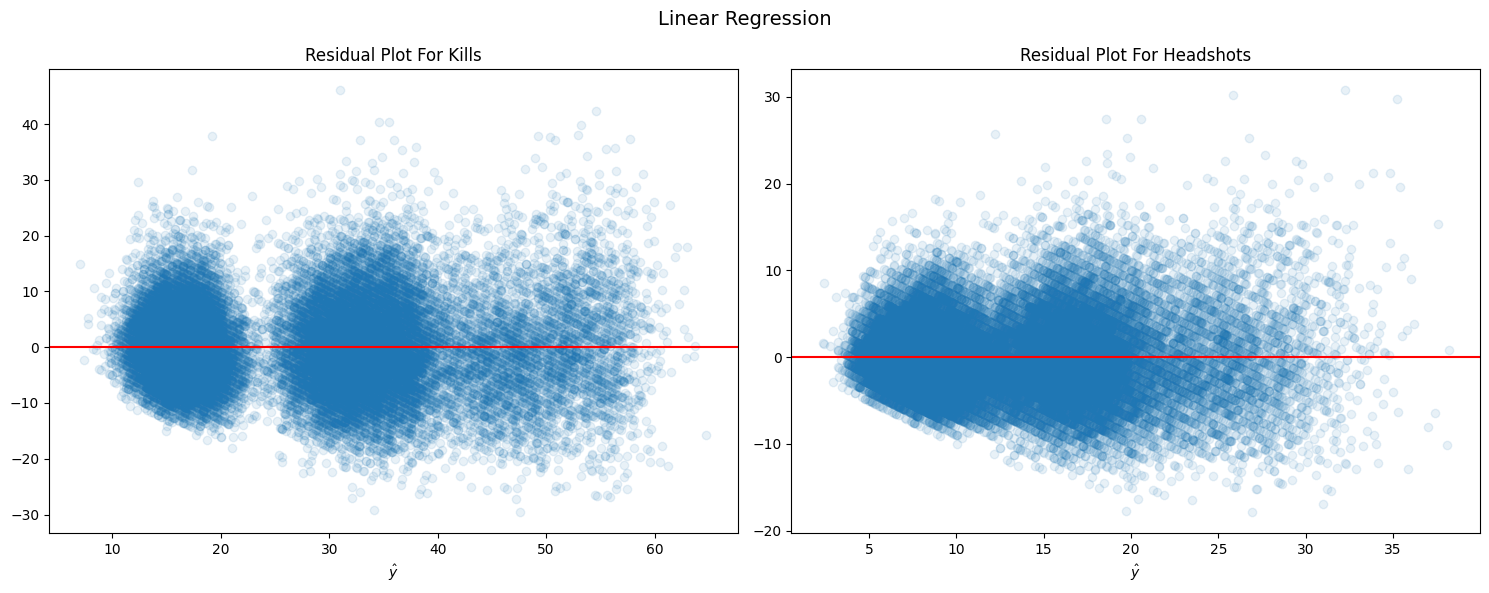

In [49]:
lr, r2, mae, rmse, y_pred_lr = model_scores(lr, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_lr, y_test, "Linear Regression")

R2 Score (Kills): 0.6963770799147342
R2 Score (Headshots): 0.6275221186315529
Mean Absolute Error (Kills): 5.907008416650281
Mean Absolute Error (Headshots): 3.5742934367200343
Root Mean Squared Error (Kills): 7.693299478184983
Root Mean Squared Error (Headshots): 4.6606791660293085


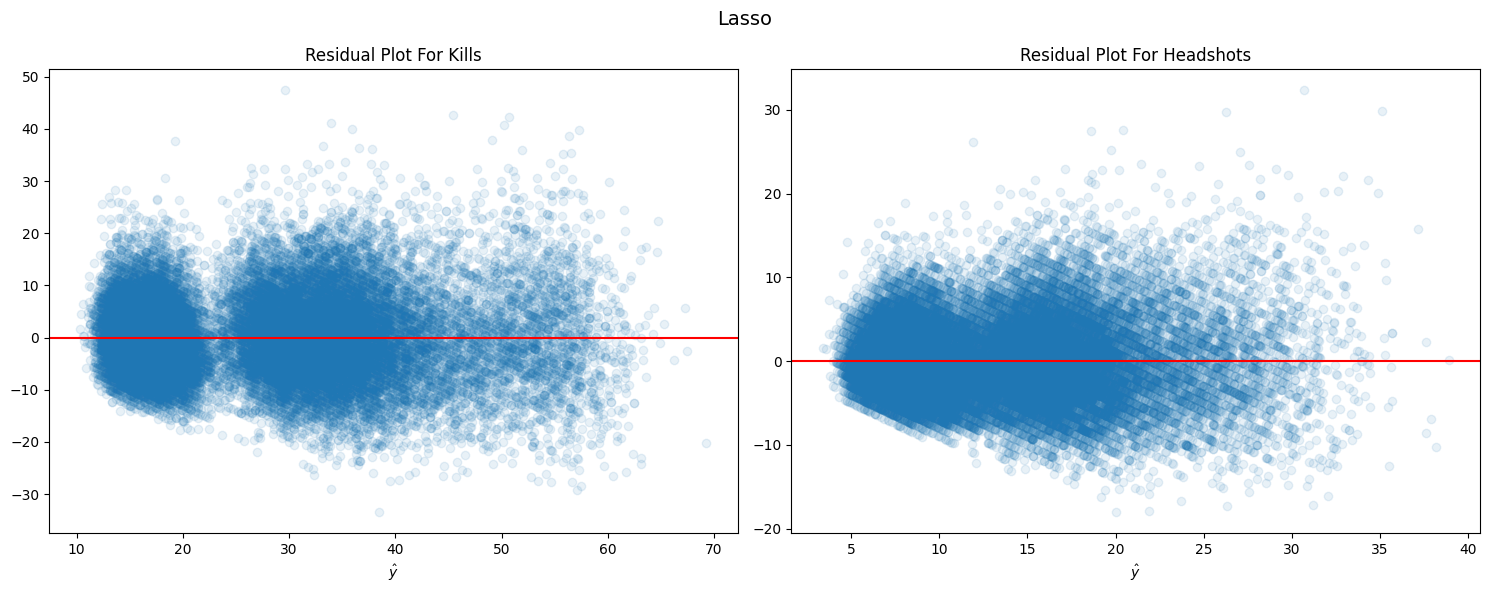

In [50]:
lasso, r2, mae, rmse, y_pred_lasso = model_scores(lasso, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_lasso, y_test, "Lasso")

R2 Score (Kills): 0.7198545932769775
R2 Score (Headshots): 0.6447141170501709
Mean Absolute Error (Kills): 5.6581366749059
Mean Absolute Error (Headshots): 3.483398896639803
Root Mean Squared Error (Kills): 7.389893016292387
Root Mean Squared Error (Headshots): 4.5518609415295606


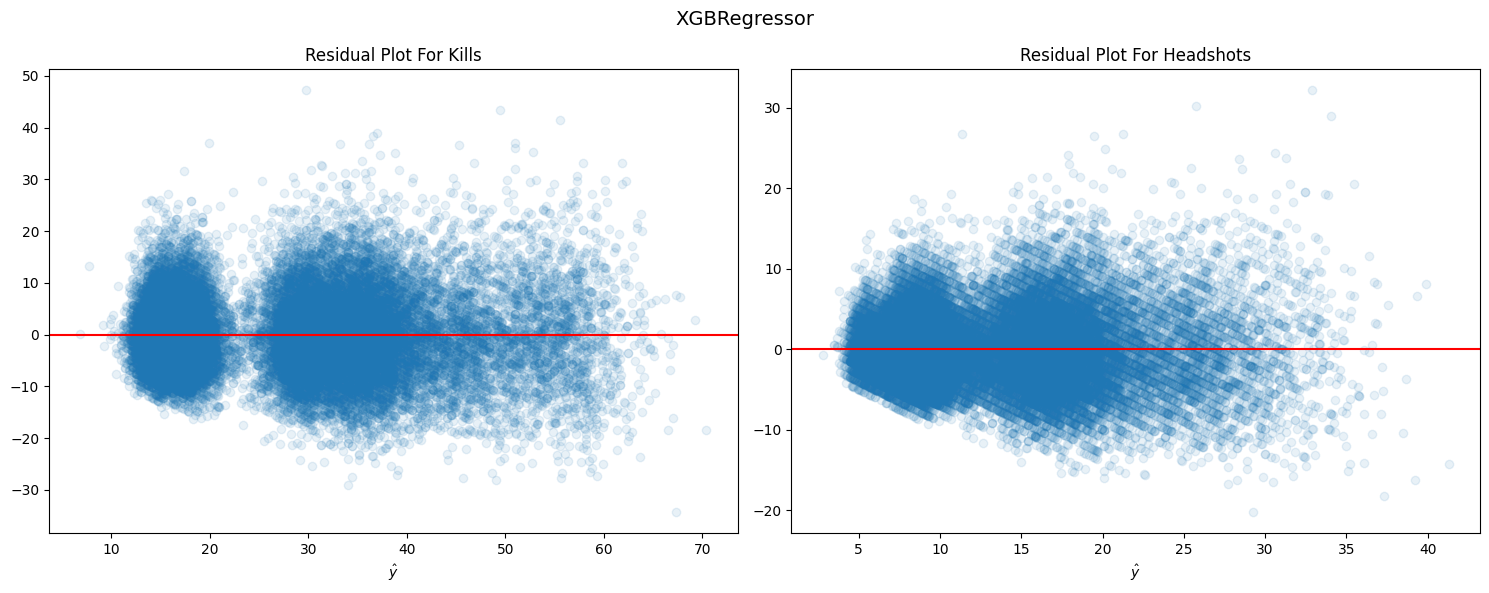

In [51]:
xgr, r2, mae, rmse, y_pred_xgr = model_scores(xgr, x_train, y_train, x_test, y_test)
plot_residuals(y_pred_xgr, y_test, "XGBRegressor")

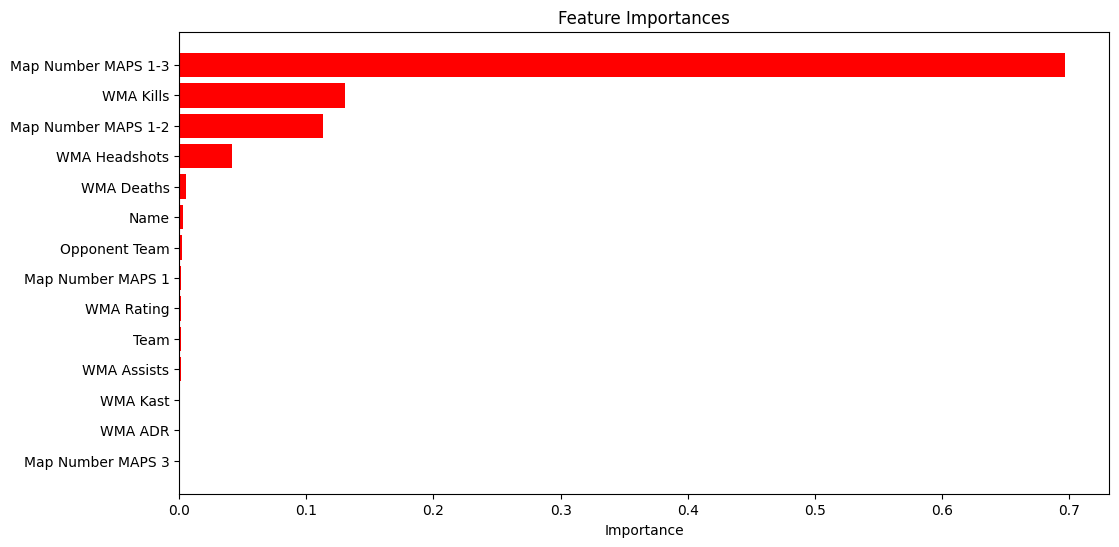

In [52]:
# Create a dictionary mapping feature importances to feature names
feature_importance_dict = dict(zip(xgr.feature_names_in_, xgr.feature_importances_))

# Sort the features by importance (ascending order)
sorted_features = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Unpack the feature names and their importances
feature_names, importances = zip(*sorted_features)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(feature_names, importances, color='red')

# Add labels and title
ax.set_xlabel('Importance')
ax.set_title('Feature Importances')

# Invert y-axis to have the most important feature at the top
plt.gca().invert_yaxis()

# Display the plot
plt.show()

## Prediction

In [54]:
model = joblib.load("xgr_model_v2.joblib")

def model_projections(name: str, team: str, opp_team: str, map_type: str):
    model_inputs = {
    "WMA Kills": 0,
    "WMA Headshots": 0,
    "WMA Assists": 0,
    "WMA Deaths": 0,
    "WMA Kast": 0,
    "WMA ADR": 0,
    "WMA Rating": 0,
    "Map Number MAPS 1": 0,
    "Map Number MAPS 1-2": 0,
    "Map Number MAPS 1-3": 0,
    "Map Number MAPS 3": 0,
    "Team": 0,
    "Opponent Team": 0,
    "Name": ""
    }
    if "(Combo)" in map_type:
        return 0
    stat_type = map_type.split()[-1]
    map_type = " ".join(map_type.split()[:2])
    df = cs_maps_and_stats[(cs_maps_and_stats["Name"] == name) & (cs_maps_and_stats["Team"] == team) & (cs_maps_and_stats["Map Number"] == map_type)]
    df_lower = cs_maps_and_stats[(cs_maps_and_stats["Name"] == name.lower()) & (cs_maps_and_stats["Team"] == team) & (cs_maps_and_stats["Map Number"] == map_type)]
    if (len(df) <= 7) & (len(df_lower) <= 7):
        return 0
    elif len(df_lower) >= 8:
        df = df_lower
        name = name.lower()
    else:
        df = df
    dot_product = df[weight_cols].tail(n).apply(lambda group: np.dot(weights[::-1], group), raw=True)
    for col in dot_product.keys():
        column = f"WMA {col}"
        model_inputs[column] = dot_product.loc[col]
    model_inputs[f"Map Number {map_type}"] = 1
    # If the data cannot be mapped using the dictionaries
    try:
        model_inputs["Name"] = player_mean_rating_dict[name]
        model_inputs["Team"] = team_std_rating_dict[team]
        model_inputs["Opponent Team"] = team_std_rating_dict[opp_team]
    except KeyError:
        return 0
    inp = [np.array(list(model_inputs.values()))]
    prediction = model.predict(inp)[0]
    if stat_type == "Headshots":
        return prediction[1]
    return prediction[0]

In [55]:
# Predictions
prediction_df = pd.DataFrame(prizepicks_lines())
prediction_df["Model Prediction"] = prediction_df.apply(lambda col: model_projections(col["Name"], col["Team"], col["Opp"], col["Type"]), axis=1)
prediction_df = prediction_df[prediction_df["Model Prediction"] != 0].drop(columns="ID")
prediction_df.reset_index(drop=True)

# Add difference and sort by teams
prediction_df.sort_values(by="Team", inplace=True)
prediction_df["Diff (+/-)"] = prediction_df["Model Prediction"] - prediction_df["Line Score"]
prediction_df["Over/Under"] = np.where(prediction_df["Line Score"] < prediction_df["Model Prediction"], "Over", "Under")

# Save to a CSV
prediction_df.to_csv("predictions.csv", index=False)

# Display
prediction_df.reset_index(drop=True)

,Game Date,Game Time,Type,Name,Team,Opp,Line Score,Model Prediction,Diff (+/-),Over/Under
0,2024-11-15,03:00:00,MAPS 1-2 Kills,HUASOPEEK,9z,FURIA,25.5,29.002472,3.502472,Over
1,2024-11-15,03:00:00,MAPS 1-2 Kills,buda,9z,FURIA,24.0,26.550444,2.550444,Over
2,2024-11-15,03:00:00,MAPS 1-2 Kills,max,9z,FURIA,25.0,27.053383,2.053383,Over
3,2024-11-15,03:00:00,MAPS 1-2 Kills,MartinezSa,9z,FURIA,29.0,29.544771,0.544771,Over
4,2024-11-15,03:00:00,MAPS 1-2 Headshots,dgt,9z,FURIA,15.0,17.509636,2.509636,Over
5,2024-11-15,03:00:00,MAPS 1-2 Headshots,HUASOPEEK,9z,FURIA,15.5,17.039318,1.539318,Over
6,2024-11-15,03:00:00,MAPS 1-2 Headshots,buda,9z,FURIA,12.0,13.584301,1.584301,Over
7,2024-11-15,03:00:00,MAPS 1-2 Headshots,MartinezSa,9z,FURIA,10.5,10.485943,-0.014057,Under
8,2024-11-15,03:00:00,MAPS 1-2 Headshots,max,9z,FURIA,13.5,15.765576,2.265576,Over
9,2024-11-15,03:00:00,MAPS 1-2 Kills,dgt,9z,FURIA,29.0,33.482899,4.482899,Over
